# kCHORDS recommendation system

# Intro
- Introduzione: definisce il problema affrontato e discute perché è interessante;

[What's a recommendation system]

## Table of contents

## Data

## Method
[content based]

## Implementation

First of all, let's import all the libraries

In [2]:
import json
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.metrics.pairwise import cosine_similarity
import yt_dlp
from essentia.standard import MusicExtractor
import requests
from fuzzywuzzy import process
from requests.auth import HTTPBasicAuth
from collections import Counter
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import spotipy
import spacy
import base64
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


# Dataset creation

Import the dataset from [Hugging Face](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset).

This is a dataset of Spotify tracks over a range of 125 different genres. Each track has some audio features associated with it.

In [56]:
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

In [57]:
df.head

<bound method NDFrame.head of         Unnamed: 0                track_id                 artists  \
0                0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1                1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2                2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3                3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4                4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   
...            ...                     ...                     ...   
113995      113995  2C3TZjDRiAzdyViavDJ217           Rainy Lullaby   
113996      113996  1hIz5L4IB9hN3WRYPOCGPw           Rainy Lullaby   
113997      113997  6x8ZfSoqDjuNa5SVP5QjvX           Cesária Evora   
113998      113998  2e6sXL2bYv4bSz6VTdnfLs        Michael W. Smith   
113999      113999  2hETkH7cOfqmz3LqZDHZf5           Cesária Evora   

                                               album_name  \
0                                                  Comedy   
1      

In [58]:
# elenco di tutti i generi presenti
df['track_genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

Removing duplicates

In [59]:
print("Df len: ", len(df.index))
print("Duplicates: ", len(df[df.duplicated(subset='track_id', keep=False)]))

df = df.drop_duplicates(subset='track_id', keep='first')
print("Df with no track_id duplicates: ", len(df.index))

Df len:  114000
Duplicates:  40900
Df with no track_id duplicates:  89741


In [60]:
df = df.drop_duplicates(subset='track_name', keep='first')
print("Df with no track_name duplicates: ", len(df.index))

Df with no track_name duplicates:  73609


Removing all the useless columns

In [61]:
df = df.rename(columns={'track_genre': 'genre'})
feat_vec = df.drop(columns=['Unnamed: 0', 'artists', 'album_name', 'track_name', 'duration_ms', 'explicit', 'key', 'mode', 'time_signature'])

Only the most popular genres are kept by filtering the dataset to include those in the `common_genres` list.

In [62]:
common_genres = [
    'acoustic', 'alt-rock', 'alternative', 'ambient', 'blues', 'classical', 'country', 'dance', 
    'disco', 'electro', 'electronic', 'folk', 'funk', 'gospel', 'hip-hop', 'house', 'indie', 'jazz', 
    'latin', 'metal', 'pop', 'rock', 'soul', 'synth-pop', 'techno', 'trance'
]

feat_vec = feat_vec[feat_vec['genre'].isin(common_genres)]

feat_vec

,track_id,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,5SuOikwiRyPMVoIQDJUgSV,73,0.676,0.4610,-6.746,0.1430,0.032200,0.000001,0.3580,0.7150,87.917,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,55,0.420,0.1660,-17.235,0.0763,0.924000,0.000006,0.1010,0.2670,77.489,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,57,0.438,0.3590,-9.734,0.0557,0.210000,0.000000,0.1170,0.1200,76.332,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,71,0.266,0.0596,-18.515,0.0363,0.905000,0.000071,0.1320,0.1430,181.740,acoustic
4,5vjLSffimiIP26QG5WcN2K,82,0.618,0.4430,-9.681,0.0526,0.469000,0.000000,0.0829,0.1670,119.949,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...
110995,7sLknEg8aVr0m5ZuCja7b3,28,0.148,0.9930,-7.696,0.0922,0.009700,0.937000,0.0376,0.0928,140.001,trance
110996,6veycwSGozeHSFQ6fbr5dC,28,0.504,0.9850,-7.305,0.0504,0.000810,0.922000,0.1250,0.3830,139.978,trance
110997,0MLEzWJQcRkc5IMAqucPbV,28,0.474,0.9950,-4.265,0.0979,0.000166,0.369000,0.1500,0.0634,150.002,trance
110998,0cRNPYxzXLNLQd1g4kKYS6,28,0.416,0.9810,-3.653,0.0943,0.000079,0.928000,0.1870,0.0662,150.054,trance


In [64]:
# list of all the current genres
genre_list = feat_vec['genre'].unique().tolist()
print(genre_list)

['acoustic', 'alt-rock', 'alternative', 'ambient', 'blues', 'classical', 'country', 'dance', 'disco', 'electro', 'electronic', 'folk', 'funk', 'gospel', 'hip-hop', 'house', 'indie', 'jazz', 'latin', 'metal', 'pop', 'rock', 'soul', 'synth-pop', 'techno', 'trance']


This step uses one-hot encoding to create new columns for each genre, indicating the:
- presence [1]
- absence [0]

of that genre for each item.

In [65]:
for item in genre_list:
    feat_vec['genre_'+item] = feat_vec['genre'].apply(lambda genre: 1 if genre == item else 0)

feat_vec

,track_id,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance
0,5SuOikwiRyPMVoIQDJUgSV,73,0.676,0.4610,-6.746,0.1430,0.032200,0.000001,0.3580,0.7150,87.917,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4qPNDBW1i3p13qLCt0Ki3A,55,0.420,0.1660,-17.235,0.0763,0.924000,0.000006,0.1010,0.2670,77.489,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1iJBSr7s7jYXzM8EGcbK5b,57,0.438,0.3590,-9.734,0.0557,0.210000,0.000000,0.1170,0.1200,76.332,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6lfxq3CG4xtTiEg7opyCyx,71,0.266,0.0596,-18.515,0.0363,0.905000,0.000071,0.1320,0.1430,181.740,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5vjLSffimiIP26QG5WcN2K,82,0.618,0.4430,-9.681,0.0526,0.469000,0.000000,0.0829,0.1670,119.949,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110995,7sLknEg8aVr0m5ZuCja7b3,28,0.148,0.9930,-7.696,0.0922,0.009700,0.937000,0.0376,0.0928,140.001,trance,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110996,6veycwSGozeHSFQ6fbr5dC,28,0.504,0.9850,-7.305,0.0504,0.000810,0.922000,0.1250,0.3830,139.978,trance,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110997,0MLEzWJQcRkc5IMAqucPbV,28,0.474,0.9950,-4.265,0.0979,0.000166,0.369000,0.1500,0.0634,150.002,trance,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110998,0cRNPYxzXLNLQd1g4kKYS6,28,0.416,0.9810,-3.653,0.0943,0.000079,0.928000,0.1870,0.0662,150.054,trance,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [66]:
# drop the genre column, with the one-hot encoding we don't need it anymore
feat_vec.drop('genre', axis=1, inplace=True)
feat_vec

,track_id,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance
0,5SuOikwiRyPMVoIQDJUgSV,73,0.676,0.4610,-6.746,0.1430,0.032200,0.000001,0.3580,0.7150,87.917,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4qPNDBW1i3p13qLCt0Ki3A,55,0.420,0.1660,-17.235,0.0763,0.924000,0.000006,0.1010,0.2670,77.489,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1iJBSr7s7jYXzM8EGcbK5b,57,0.438,0.3590,-9.734,0.0557,0.210000,0.000000,0.1170,0.1200,76.332,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6lfxq3CG4xtTiEg7opyCyx,71,0.266,0.0596,-18.515,0.0363,0.905000,0.000071,0.1320,0.1430,181.740,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5vjLSffimiIP26QG5WcN2K,82,0.618,0.4430,-9.681,0.0526,0.469000,0.000000,0.0829,0.1670,119.949,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110995,7sLknEg8aVr0m5ZuCja7b3,28,0.148,0.9930,-7.696,0.0922,0.009700,0.937000,0.0376,0.0928,140.001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110996,6veycwSGozeHSFQ6fbr5dC,28,0.504,0.9850,-7.305,0.0504,0.000810,0.922000,0.1250,0.3830,139.978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110997,0MLEzWJQcRkc5IMAqucPbV,28,0.474,0.9950,-4.265,0.0979,0.000166,0.369000,0.1500,0.0634,150.002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110998,0cRNPYxzXLNLQd1g4kKYS6,28,0.416,0.9810,-3.653,0.0943,0.000079,0.928000,0.1870,0.0662,150.054,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Two rows with extreme values for popularity, loudness, and tempo are added to the dataset to normalize the data. Then, those features are scaled to a 0-1 range using MinMax scaling to ensure they are comparable.

In [67]:
min_row = {'popularity': '0', 'loudness': '-60', 'tempo': '0'}
max_row = {'popularity': '100', 'loudness': '0', 'tempo': '250'}

min_row_df = pd.DataFrame([min_row])
max_row_df = pd.DataFrame([max_row])

feat_vec = pd.concat([feat_vec, min_row_df], ignore_index=True)
feat_vec = pd.concat([feat_vec, max_row_df], ignore_index=True)

# scale popularity, loudness, and tempo features to 0-1
scale = ['popularity', 'loudness', 'tempo']
scaler = MinMaxScaler()
feat_vec[scale] = scaler.fit_transform(feat_vec[scale])

feat_vec = feat_vec.iloc[:-2]

feat_vec

,track_id,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance
0,5SuOikwiRyPMVoIQDJUgSV,0.73,0.676,0.4610,0.861422,0.1430,0.032200,0.000001,0.3580,0.7150,0.351668,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4qPNDBW1i3p13qLCt0Ki3A,0.55,0.420,0.1660,0.691755,0.0763,0.924000,0.000006,0.1010,0.2670,0.309956,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1iJBSr7s7jYXzM8EGcbK5b,0.57,0.438,0.3590,0.813089,0.0557,0.210000,0.000000,0.1170,0.1200,0.305328,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6lfxq3CG4xtTiEg7opyCyx,0.71,0.266,0.0596,0.671050,0.0363,0.905000,0.000071,0.1320,0.1430,0.726960,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5vjLSffimiIP26QG5WcN2K,0.82,0.618,0.4430,0.813947,0.0526,0.469000,0.000000,0.0829,0.1670,0.479796,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12303,7sLknEg8aVr0m5ZuCja7b3,0.28,0.148,0.9930,0.846056,0.0922,0.009700,0.937000,0.0376,0.0928,0.560004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12304,6veycwSGozeHSFQ6fbr5dC,0.28,0.504,0.9850,0.852380,0.0504,0.000810,0.922000,0.1250,0.3830,0.559912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12305,0MLEzWJQcRkc5IMAqucPbV,0.28,0.474,0.9950,0.901554,0.0979,0.000166,0.369000,0.1500,0.0634,0.600008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12306,0cRNPYxzXLNLQd1g4kKYS6,0.28,0.416,0.9810,0.911454,0.0943,0.000079,0.928000,0.1870,0.0662,0.600216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
feat_vec.to_csv('DATASET_TO_IMPORT.csv', sep='\t')

In [15]:
feat_vec.columns

Index(['Unnamed: 0.6', 'Unnamed: 0.5', 'Unnamed: 0.4', 'Unnamed: 0.3',
       'Unnamed: 0.2', 'Unnamed: 0.1', 'track_id', 'popularity',
       'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'genre_acoustic',
       'genre_alt-rock', 'genre_alternative', 'genre_ambient', 'genre_blues',
       'genre_classical', 'genre_country', 'genre_dance', 'genre_disco',
       'genre_electro', 'genre_electronic', 'genre_folk', 'genre_funk',
       'genre_gospel', 'genre_hip-hop', 'genre_house', 'genre_indie',
       'genre_jazz', 'genre_latin', 'genre_metal', 'genre_pop', 'genre_rock',
       'genre_soul', 'genre_synth-pop', 'genre_techno', 'genre_trance'],
      dtype='object')

An object for similarity calculation is created by dropping the unnecessary columns for these operations.

In [16]:
song_dataset_cosine_sim = feat_vec.drop('track_id', axis=1)

In [17]:
song_dataset_cosine_sim = song_dataset_cosine_sim.loc[:, ~song_dataset_cosine_sim.columns.str.contains('^Unnamed')]
song_dataset_cosine_sim.columns

Index(['popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'genre_acoustic', 'genre_alt-rock', 'genre_alternative',
       'genre_ambient', 'genre_blues', 'genre_classical', 'genre_country',
       'genre_dance', 'genre_disco', 'genre_electro', 'genre_electronic',
       'genre_folk', 'genre_funk', 'genre_gospel', 'genre_hip-hop',
       'genre_house', 'genre_indie', 'genre_jazz', 'genre_latin',
       'genre_metal', 'genre_pop', 'genre_rock', 'genre_soul',
       'genre_synth-pop', 'genre_techno', 'genre_trance'],
      dtype='object')

# Recommendation System

## Feature extraction  
In this section, the input song is processed to extract features matching the dataset, following these steps:
1. **Download the Audio**  
   - Extracts the MP3 from the video.  

2. **Extract Song Features**  
   Using **MusicExtractor**, the system retrieves key musical attributes, including:  
   - Danceability  
   - Energy  
   - Loudness  
   - Speechiness  
   - Acousticness  
   - Instrumentalness  
   - Liveness  
   - Valence  
   - Tempo  

3. **Calculate Popularity**  
   The system determines a song’s popularity by analyzing YouTube metadata, including:  
   - Likes  
   - Comments  
   - Views  

4. **Extract Genre**  
   Since the Spotify API does not provide song-specific genres (only artist-related genres), the system identifies the genre through:  

   - **Spotify/Get_Genre_By_Scraped_Artist**: [Scrapes](https://github.com/Kespers/kCHORDS/tree/main/chords-scraper) the chords web-site to extract the artist’s name and fetches the genre from Spotify.  
   - **Spotify/Get_Genre_By_Possible_Artist**: If the first method fails, the system applies **SpaCy NLP** to extract artist names from YouTube metadata (title, description, tags). The most likely artist is then queried in the Spotify API to determine the most common genre.

### Download MP3 audio  
The audio is downloaded and converted into the MP3 format using the libmp3lame codec for optimal feature extraction.

In [ ]:
def convert_to_optimal_codec(song_path, output_path):
    print("\t convertin codec")
    os.system(f"ffmpeg -i {song_path} -acodec libmp3lame {output_path} -y")

def download_mp3(song):
	id = song['Yt_Id']
	link = song['Yt_Link']
      
	raw_path = f'./songs/{id}/raw_song.mp3'
	output_path = f'./songs/{id}/song.mp3'
	ydl_opts = {
		'format': 'bestaudio/best',
		'extractaudio': True,
		'outtmpl': raw_path,
		'noplaylist': True
	}

	try:
		with yt_dlp.YoutubeDL(ydl_opts) as ydl:
			info_dict = ydl.extract_info(link, download=True)
			song_name = info_dict['title']

			convert_to_optimal_codec(raw_path, output_path)

			return output_path
	except Exception as e:
		raise e

def download_songs_mp3(songs):
    with ThreadPoolExecutor() as executor:
        list(executor.map(download_mp3, songs))

In [68]:
# getting yt video data by id
def get_video_data(query: str = None, video_id: str = None):
    YT_KEY = os.getenv('GOOGLE_TOKEN')

    if not YT_KEY:
        raise ValueError("Google API key is missing. Please set 'GOOGLE_TOKEN' in the environment variables.")

    base_url = 'https://www.googleapis.com/youtube/v3'

    if video_id:
        url = f'{base_url}/videos'
        params = {
            'key': YT_KEY,
            'id': video_id,
            'part': 'snippet,statistics,contentDetails',
        }
    elif query:
        url = f'{base_url}/search'
        params = {
            'key': YT_KEY,
            'q': query,
            'part': 'snippet',
            'type': 'video',
            'maxResults': 1
        }
    else:
        raise ValueError("Devi fornire un video_id o una query!")

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        if video_id:
            if 'items' in data and len(data['items']) > 0:
                video_info = data['items'][0]
                return {
                    'video_id': video_id,
                    'title': video_info['snippet']['title'],
                    'description': video_info['snippet']['description'],
                    'tags': video_info['snippet'].get('tags', []),
                    'view_count': video_info['statistics']['viewCount'],
                    'like_count': video_info['statistics'].get('likeCount', 'N/A'),
                    'comment_count': video_info['statistics'].get('commentCount', 'N/A'),
                    'duration': video_info['contentDetails']['duration']
                }
        elif query:
            if 'items' in data and len(data['items']) > 0:
                first_video = data['items'][0]
                video_id = first_video['id']['videoId']
                return {
                    'video_id': video_id,
                    'title': first_video['snippet']['title'],
                    'description': first_video['snippet']['description'],
                    'channel_title': first_video['snippet']['channelTitle'],
                    'video_link': f'https://www.youtube.com/watch?v={video_id}'
                }
    else:
        print(f"Errore durante la richiesta: {response.status_code}")
    return None


def get_video_by_id(video_id):
    return get_video_data(video_id=video_id)


def get_video_by_name(query):
    return get_video_data(query=query)

###  Extracting song feature

In [19]:
def get_artist_genre(artist_name, dataset_genres, spotify):
    if not artist_name or artist_name.isspace():
        return []
    
    result = spotify.search(q=artist_name, type='artist', limit=1)
    genres = []
    if result['artists']['items']:
        genres = result['artists']['items'][0].get('genres', [])
    
    return genres

def get_song_info(song_id, spotify):
    try:
        track_info = spotify.track(song_id)
        
        song_data = {
            "name": track_info["name"],
            "artists": [artist["name"] for artist in track_info["artists"]],
            "album": track_info["album"]["name"],
            "link": track_info["external_urls"]["spotify"],
        }
        return song_data

    except Exception as e:
        print(f"Errore durante il recupero delle informazioni della canzone: {e}")
        return None

def get_client():
    CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')
    CLIENT_SECRET = os.getenv('SPOTIFY_CLIENT_SECRET')

    # Autenticazione con Spotify
    client_credentials_manager = SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET
    )

    return spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [20]:
def extract_person_from_video_data(video_data):
    nlp = spacy.load('en_core_web_sm')
    text_to_search = video_data['title'] + " " + video_data['description'] + " " + " ".join(video_data['tags'])
    doc = nlp(text_to_search)

    person_entities = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']

    return person_entities if person_entities else None

def dataset_mapping(genres):
    most_similar_genre = None
    highest_similarity = 0

    for genre in genres:
        best_match = process.extractOne(genre, genre_list)
        if best_match:
            similarity_score = best_match[1]
            if similarity_score > highest_similarity:
                highest_similarity = similarity_score
                most_similar_genre = best_match[0]

    return most_similar_genre

def get_genre_df(artists, video_data):

    def get_from_artist(artists):
        if not artists:
            return None
        
        genres = []
        for artist in artists:
            raw_genre = get_artist_genre(artist, genre_list, spotify=get_client())
            if raw_genre:
                artist_genre = dataset_mapping(raw_genre)
                
                if artist_genre:
                    genres.append(artist_genre)
            
        genre_counts = Counter(genres)
        return genre_counts.most_common(1)[0][0] if genre_counts else None

    genre = get_from_artist(artists)
    if not genre:
        genre = get_from_artist(extract_person_from_video_data(video_data))

    genre_df = pd.DataFrame() 

    print(f"\tTitle: {video_data['title']} - Genre: ", genre)

    # encoding
    genre_encoding = {f'genre_{g}': [1 if g == genre else 0] for g in genre_list}
    genre_df = pd.DataFrame(genre_encoding)

    return genre_df

### Calculate Popularity

In [21]:
def get_popularity_score(video_info):
    view_count = int(video_info['view_count'])
    like_count = int(video_info['like_count'])
    comment_count = int(video_info['comment_count'])

    max_view_count = 100000  
    max_like_count = 1000    
    max_comment_count = 100 

    
    normalized_view_count = view_count / max_view_count
    normalized_like_count = like_count / max_like_count
    normalized_comment_count = comment_count / max_comment_count

    
    normalized_view_count = min(normalized_view_count, 1)
    normalized_like_count = min(normalized_like_count, 1)
    normalized_comment_count = min(normalized_comment_count, 1)

    
    weight_view_count = 0.2
    weight_like_count = 0.3
    weight_comment_count = 0.25

    
    popularity_score = (
        weight_view_count * normalized_view_count +
        weight_like_count * normalized_like_count +
        weight_comment_count * normalized_comment_count
    )

    
    return round(popularity_score, 2)

def get_song_stats(song_path, video_data):
	music_extractor = MusicExtractor(
		lowlevelStats=['mean', 'stdev'],
		rhythmStats=['mean', 'stdev'],
		tonalStats=['mean', 'stdev']
	)
	
	features, _ = music_extractor(song_path)
	
	stats = {
		"danceability": features["rhythm.danceability"], 
		"energy": features["lowlevel.spectral_energy.mean"],
		"loudness": features["lowlevel.average_loudness"], 
		"speechiness": features["lowlevel.spectral_entropy.mean"],
		"acousticness": features["lowlevel.melbands_flatness_db.mean"],
		"instrumentalness": features["lowlevel.pitch_salience.mean"],
		"liveness": features["lowlevel.spectral_flux.mean"],
		"valence": features["tonal.chords_strength.mean"],
		"tempo": features["rhythm.bpm"],
		"popularity": get_popularity_score(video_data)
	}
	
	song_stats_df = pd.DataFrame([stats])
	
	min_row = {'popularity': '0', 'loudness': '-60', 'tempo': '0'}
	max_row = {'popularity': '100', 'loudness': '0', 'tempo': '250'}

	min_row_df = pd.DataFrame([min_row])
	max_row_df = pd.DataFrame([max_row])

	song_stats_df = pd.concat([song_stats_df, min_row_df], ignore_index=True)
	song_stats_df = pd.concat([song_stats_df, max_row_df], ignore_index=True)

	scale = ['popularity', 'loudness', 'tempo']
	scaler = MinMaxScaler()
	song_stats_df[scale] = scaler.fit_transform(song_stats_df[scale])

	song_stats_df = song_stats_df.iloc[:-2]

	return song_stats_df

## Dataframe creation

In [23]:
def process_song(song):
	video_id = song['Yt_Id']
	song_path = song['Song_Path']
	artists = song['Artists']

	print(f"Processing: {song_path}")

	video_data = get_video_by_id(video_id)
	genre_df = get_genre_df(artists, video_data)
	song_stat_df = get_song_stats(song_path, video_data)

	song_data_df = pd.concat([song_stat_df, genre_df], axis=1)

	# Add Artists and Video ID columns
	song_data_df['Artists'] = ', '.join(artists)
	song_data_df['Video_ID'] = video_id

	if not os.path.exists('./df'):
		os.makedirs('./df')

	song_data_df.to_csv(f'./df/{video_id}_df.csv', index=False)


def extract_songs_data(songs):
    with ThreadPoolExecutor() as executor:
        list(executor.map(process_song, songs))


In [24]:
def get_recommendation(dataset, song_df, genres, recommendation_count):
		similarity_scores = cosine_similarity(dataset, song_df)

		dataset['similarity_score'] = similarity_scores

		# fai il coso dei generi
		return dataset \
			.sort_values(by='similarity_score', ascending=False) \
			.head(recommendation_count) \
			['track_id']

## Recommendation

In [29]:
songs = [
    {
        'Yt_Link': 'https://www.youtube.com/watch?v=unRjK82bDLw',
        'Yt_Id': 'unRjK82bDLw',
        'Artists': [
            'Marco Mengoni'
        ]
    },
    {
        'Yt_Link': 'https://www.youtube.com/watch?v=E3sP6AXKuYg',
        'Yt_Id': 'E3sP6AXKuYg',
        'Artists': [
            'David Gilmour'
        ]
    },
    {
        'Yt_Link': 'https://www.youtube.com/watch?v=nVa0GPeuVk4',
        'Yt_Id': 'nVa0GPeuVk4',
        'Artists': [
            'Olly', 
            'Angelina Mango', 
            'JVLI'
        ]
    },
    {
        'Yt_Link': 'https://www.youtube.com/watch?v=u-cx3TN7Sho',
        'Yt_Id': 'u-cx3TN7Sho',
        'Artists': [
            'Rose Villain',
            'Guè'
        ]
    },
    {
        'Yt_Link': 'https://www.youtube.com/watch?v=v2AC41dglnM',
        'Yt_Id': 'v2AC41dglnM',
        'Artists': [
            'AC/DC'
        ]
    }
]

In [ ]:
download_songs_mp3(songs)

In [30]:
# Associating the MP3 file path to each song
for song in songs:
    song['Song_Path'] = f'./songs/{song["Yt_Id"]}/song.mp3'
    print(song['Song_Path'])

./songs/unRjK82bDLw/song.mp3
./songs/E3sP6AXKuYg/song.mp3
./songs/nVa0GPeuVk4/song.mp3
./songs/u-cx3TN7Sho/song.mp3
./songs/v2AC41dglnM/song.mp3


In [ ]:
extract_songs_data(songs)

In [37]:
# Concatenating dataframes for all songs
song_df = pd.concat(
    [pd.read_csv(f"./df/{song['Yt_Id']}_df.csv") for song in songs],
    ignore_index=True,
)

In [38]:
song_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance
0,1.029173,0.023112,1.0,7.545177,0.202679,0.542803,0.066513,0.544834,0.503434,0.0075,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.183636,0.031970,1.0,7.142763,0.268807,0.521351,0.076659,0.525631,0.493890,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1.168210,0.034790,1.0,7.408294,0.230346,0.538261,0.077632,0.527097,0.387358,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1.193732,0.039334,1.0,7.236877,0.259844,0.470456,0.096940,0.514170,0.560008,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1.194661,0.020659,1.0,7.903380,0.149156,0.585290,0.074827,0.573681,0.535406,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


The column averages are calculated to summarize the data and create an object that holds the central value for each feature.

This object is then used to compare the input song with the dataset for similarity calculations.

In [70]:
column_averages = song_df.mean()

averages_cosine_sim = pd.DataFrame([column_averages], index=['Average'])

averages_cosine_sim = averages_cosine_sim.loc[:, ~averages_cosine_sim.columns.str.contains('^Unnamed')]

Calculation of a similarity score for each song in the dataset to rank them based on this score and generate recommendations.

In [72]:
similarity_scores = cosine_similarity(song_dataset_cosine_sim, averages_cosine_sim)
 
feat_vec['similarity_score'] = similarity_scores
 
top_similarities = feat_vec.sort_values(by='similarity_score', ascending=False).head(5)

top_similarities

,Unnamed: 0.1,track_id,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance,similarity_score
8207,40421.0,0nFYYqz5suiZ7lVh2FK4wL,0.42,0.164,0.749,0.918992,0.0381,0.4250,0.00965,0.121,0.0721,0.318896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.642670
10562,91524.0,0puCOCSanni13tgXPVq192,0.01,0.365,0.517,0.863218,0.0243,0.0622,0.00000,0.265,0.0777,0.375448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.642518
3885,16573.0,02bERDuJxtWLvIApFJn5Ba,0.30,0.258,0.637,0.892043,0.0323,0.2740,0.00000,0.111,0.2020,0.356076,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640395
577,637.0,18k8IlS52uxRWObykDUZFG,0.60,0.236,0.578,0.881949,0.0404,0.3270,0.00015,0.206,0.2270,0.301468,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640062
2962,8397.0,2oPv5XfZvGsPD8m7oBl5aJ,0.00,0.132,0.420,0.845004,0.0368,0.2090,0.00293,0.110,0.1850,0.183428,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.638424


Formatting the recommendations to create an object containing the song links and key information.

In [73]:
recommended_songs = [get_song_info(track_id, get_client()) for track_id in top_similarities['track_id']]

recommended_songs

[{'name': 'Cordeiro e Leão (Ao Vivo)',
  'artists': ['Central 3'],
  'album': 'Cordeiro e Leão (Ao Vivo)',
  'link': 'https://open.spotify.com/track/0nFYYqz5suiZ7lVh2FK4wL'},
 {'name': 'Ode To My Family',
  'artists': ['The Cranberries'],
  'album': 'Los Clásicos del Pop 90s',
  'link': 'https://open.spotify.com/track/0puCOCSanni13tgXPVq192'},
 {'name': 'Bolava Vitthal Pahava Vitthal',
  'artists': ['Jayateerth Mevundi'],
  'album': 'Jayateerth Mevundi',
  'link': 'https://open.spotify.com/track/02bERDuJxtWLvIApFJn5Ba'},
 {'name': 'The Joke',
  'artists': ['Brandi Carlile'],
  'album': 'By the Way, I Forgive You',
  'link': 'https://open.spotify.com/track/18k8IlS52uxRWObykDUZFG'},
 {'name': 'The Night',
  'artists': ['The Moody Blues'],
  'album': 'Fiesta temática 60s',
  'link': 'https://open.spotify.com/track/2oPv5XfZvGsPD8m7oBl5aJ'}]

# Evaluation  
The performance of the recommendation system is tested through the following steps:

1. Collect the top 5 favorite songs of 10 users.
2. Generate recommendations based on these songs using two methods:
   - Basic content-based
   - Content-based, keeping only songs with the most common genre among the preferred ones.
3. Create a playlist for each user with the recommended songs.
4. Conduct a survey to assess the quality of the recommendations.
5. Calculate the performance metrics.

## Get recommendations of users
The favorite songs are saved in files of the format `./evaluation/fav_songs/{USER_ID}.json`.

In [40]:
import os
import json

users_fav_songs = []

for i in range(1, 11):
	file_path = f'./evaluation/fav_songs/{i}.json'
	if os.path.exists(file_path):
		with open(file_path, 'r') as file:
			user_songs = json.load(file)
			for song in user_songs:
				song['Song_Path'] = f'./songs/{song["Yt_Id"]}/song.mp3'
				song.pop('id', None)  # Remove the id field if it exists
			users_fav_songs.append({'Songs': user_songs, 'Id': i})

users_fav_songs[0]


{'Songs': [{'Yt_Link': 'https://www.youtube.com/watch?v=7YvAYIJSSZY',
   'Yt_Id': '7YvAYIJSSZY',
   'Artists': ['Rockwell'],
   'Song_Path': './songs/7YvAYIJSSZY/song.mp3'},
  {'Yt_Link': 'https://www.youtube.com/watch?v=3GwjfUFyY6M',
   'Yt_Id': '3GwjfUFyY6M',
   'Artists': ['Kool & The Gang'],
   'Song_Path': './songs/3GwjfUFyY6M/song.mp3'},
  {'Yt_Link': 'https://www.youtube.com/watch?v=htgr3pvBr-I',
   'Yt_Id': 'htgr3pvBr-I',
   'Artists': ['Toto'],
   'Song_Path': './songs/htgr3pvBr-I/song.mp3'},
  {'Yt_Link': 'https://www.youtube.com/watch?v=MA3OVz-dpzI',
   'Yt_Id': 'MA3OVz-dpzI',
   'Artists': ['Squallor'],
   'Song_Path': './songs/MA3OVz-dpzI/song.mp3'},
  {'Yt_Link': 'https://www.youtube.com/watch?v=o6aJJ6Q5zhg',
   'Yt_Id': 'o6aJJ6Q5zhg',
   'Artists': ['TOMMY CASH'],
   'Song_Path': './songs/o6aJJ6Q5zhg/song.mp3'}],
 'Id': 1}

In [ ]:
for user_songs in users_fav_songs:
	print("\n\n\nProcessing user: ", user_songs['Id'])
	download_songs_mp3(user_songs['Songs'])

In [ ]:
for user_songs in users_fav_songs:
	print("\n\n\nProcessing user: ", user_songs['Id'])
	extract_songs_data(user_songs['Songs'])

In [67]:
users_df = []

for user_songs in users_fav_songs:
	user_song_df = pd.concat(
		[pd.read_csv(f"./df/{song['Yt_Id']}_df.csv") for song in user_songs['Songs']],
		ignore_index=True,
	)
	users_df.append(user_song_df)

users_df[0]

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance,Artists,Video_ID
0,1.555607,0.018258,1.0,7.731660,0.164686,0.507180,0.074870,0.530233,0.490187,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rockwell,7YvAYIJSSZY
1,1.947881,0.018525,1.0,7.580819,0.177774,0.567735,0.075016,0.527196,0.481487,0.0075,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Kool & The Gang,3GwjfUFyY6M
2,1.206299,0.016247,1.0,7.837966,0.146385,0.588250,0.072917,0.489380,0.380943,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,toto,htgr3pvBr-I
3,1.131466,0.019871,1.0,7.586553,0.171737,0.551796,0.072023,0.512603,0.472217,0.0075,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Squallor,MA3OVz-dpzI
4,1.107264,0.047339,1.0,7.475175,0.232909,0.468376,0.105459,0.533753,0.478913,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,TOMMY CASH,o6aJJ6Q5zhg


In [68]:
similarity_df = [df.drop(columns=['Artists', 'Video_ID']) for df in users_df]
similarity_df[1]

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance
0,1.288900,0.047113,1.0,7.725337,0.203537,0.526613,0.108169,0.621465,0.608626,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1.197234,0.034435,1.0,7.717242,0.187582,0.586884,0.098828,0.538202,0.415386,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1.162408,0.032681,1.0,7.822676,0.145040,0.579206,0.093396,0.536339,0.615801,0.0064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1.252538,0.035167,1.0,7.348411,0.274081,0.524823,0.084495,0.557368,0.415985,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0.999874,0.025293,1.0,7.429679,0.216206,0.564732,0.071162,0.534728,0.624762,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [100]:
def get_similarity_scores(song_df):
	column_averages = song_df.mean()

	averages_cosine_sim = pd.DataFrame([column_averages], index=['Average'])

	averages_cosine_sim = averages_cosine_sim.loc[:, ~averages_cosine_sim.columns.str.contains('^Unnamed')]

	return cosine_similarity(song_dataset_cosine_sim, averages_cosine_sim)

In [109]:
# basic content base
def content_based_recommendation(song_df, idx):
	similarity_scores = get_similarity_scores(song_df)
	
	_feat_vec = feat_vec
	_feat_vec['similarity_score'] = similarity_scores

	top_similarities = _feat_vec.sort_values(by='similarity_score', ascending=False).head(5)

	top_similarities.to_csv(f'./evaluation/recommends/{idx}_normal.csv', index=False)

	recommended_songs = [get_song_info(track_id, get_client()) for track_id in top_similarities['track_id']]

	return recommended_songs

In [110]:
# content base with favourite genre
def content_based_recommendation_fav_genre(song_df, idx):
	similarity_scores = get_similarity_scores(song_df)
	
	fav_genre = song_df.filter(like='genre_').sum().idxmax().replace('genre_', '')

	_feat_vec = feat_vec[feat_vec['genre_' + fav_genre] == 1].copy()
	_feat_vec['similarity_score'] = similarity_scores[:len(_feat_vec)]

	top_similarities = _feat_vec.sort_values(by='similarity_score', ascending=False).head(5)

	top_similarities.to_csv(f'./evaluation/recommends/{idx}_fav_genre.csv', index=False)

	recommended_songs = [get_song_info(track_id, get_client()) for track_id in top_similarities['track_id']]

	return recommended_songs

In [ ]:
recommends = []

for idx, df in enumerate(similarity_df, start=1):
	recommends.append({
		'id': idx,
		'normal': content_based_recommendation(df, idx),
		'fav_song': content_based_recommendation_fav_genre(df, idx)
	})

recommends

The recommended songs are saved into individual JSON files of the format `/evaluation/recommends/{USER_ID}.json.`

In [112]:
for recommend in recommends:
	recommend_copy = recommend.copy()
	recommend_copy.pop('id', None)
	file_path = f"./evaluation/recommends/{recommend['id']}.json"
	os.makedirs(os.path.dirname(file_path), exist_ok=True)
	with open(file_path, 'w') as file:
		json.dump(recommend_copy, file, indent=4)

## Results
A survey was administered asking users to rate the 10 songs on a scale from 1 to 5, with an additional question at the end asking how closely the recommendations matched their musical tastes.

In [3]:
results = pd.read_csv('./evaluation/results/results.csv')
results

,id,1_song_rating,2_song_rating,3_song_rating,4_song_rating,5_song_rating,6_song_rating,7_song_rating,8_song_rating,9_song_rating,10_song_rating,overall
0,8,5,3,1,3,4,3,4,5,4,4,Abbastanza
1,1,1,2,2,1,1,1,1,1,1,1,Per niente
2,3,2,3,4,3,2,2,2,2,2,2,Per niente
3,2,1,3,4,1,1,4,1,1,1,1,Abbastanza
4,5,2,2,1,1,1,2,1,2,2,1,Per niente
5,4,2,1,3,1,1,1,4,1,3,1,Per niente
6,6,1,1,3,1,2,1,1,1,3,1,Per niente
7,7,1,1,1,4,1,2,1,1,1,1,Per niente
8,9,2,4,2,1,1,1,1,1,1,2,Per niente
9,10,2,4,3,1,1,3,2,2,4,3,Abbastanza


Users were asked to rate their overall experience.

It's clear that the general sentiment isn't very positive, with a strong predominance of "Per niente" in the overall responses, meaning the experience was considered very bad.

In [4]:
counts = results['overall'].value_counts()
print("Bad:", counts.get('Per niente', 0))
print("Fair:", counts.get('Abbastanza', 0))
print("Good:", counts.get('Molto', 0))

Bad: 7
Fair: 3
Good: 0


Now let's visualize the ratings.

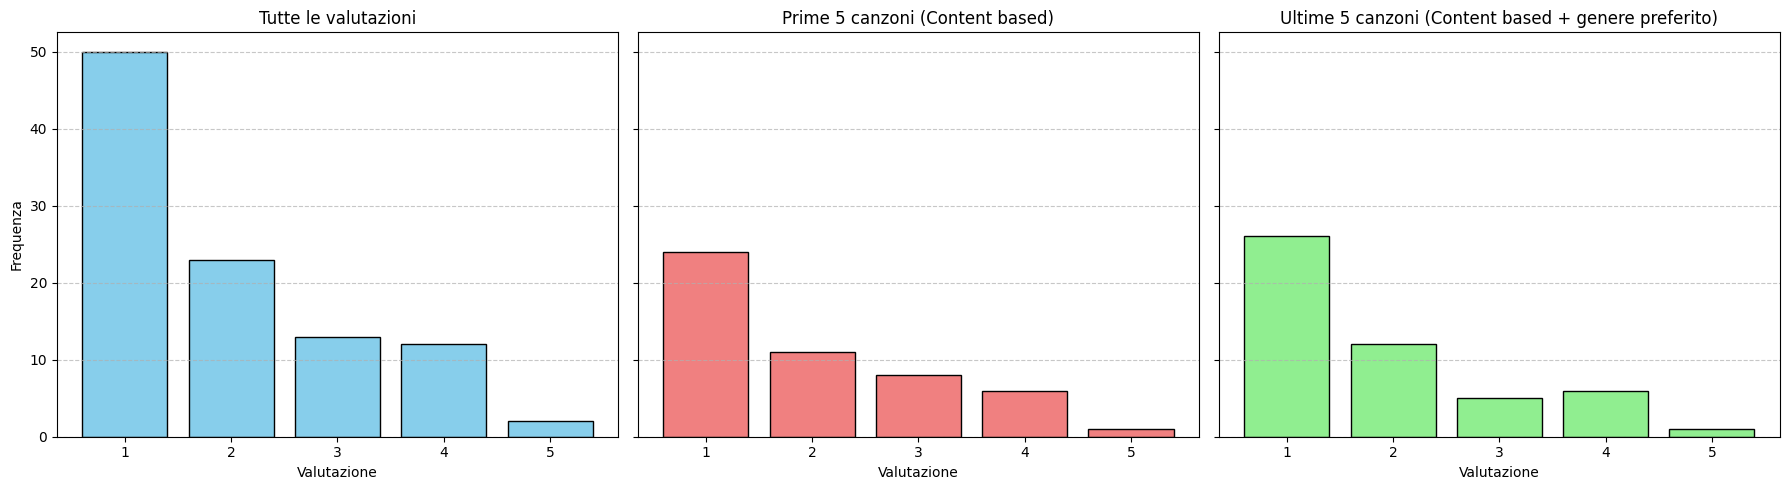

In [5]:
ratings_columns = results.columns[1:-1]
# Creazione delle suddivisioni per i due gruppi di raccomandazione
ratings_group1 = ratings_columns[:5]  # Prime 5 canzoni
ratings_group2 = ratings_columns[5:]  # Ultime 5 canzoni

# Conta la frequenza dei valori per i tre casi
value_counts_all = pd.Series(results[ratings_columns].values.flatten()).value_counts().sort_index()
value_counts_group1 = pd.Series(results[ratings_group1].values.flatten()).value_counts().sort_index()
value_counts_group2 = pd.Series(results[ratings_group2].values.flatten()).value_counts().sort_index()

# Creazione del grafico con tre istogrammi affiancati
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Primo grafico - Tutti i dati
axes[0].bar(value_counts_all.index, value_counts_all.values, color='skyblue', edgecolor='black')
axes[0].set_title("Tutte le valutazioni")
axes[0].set_xlabel("Valutazione")
axes[0].set_ylabel("Frequenza")
axes[0].set_xticks(range(1, 6))
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Secondo grafico - Prime 5 canzoni
axes[1].bar(value_counts_group1.index, value_counts_group1.values, color='lightcoral', edgecolor='black')
axes[1].set_title("Prime 5 canzoni (Content based)")
axes[1].set_xlabel("Valutazione")
axes[1].set_xticks(range(1, 6))
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Terzo grafico - Ultime 5 canzoni
axes[2].bar(value_counts_group2.index, value_counts_group2.values, color='lightgreen', edgecolor='black')
axes[2].set_title("Ultime 5 canzoni (Content based + genere preferito)")
axes[2].set_xlabel("Valutazione")
axes[2].set_xticks(range(1, 6))
axes[2].grid(axis="y", linestyle="--", alpha=0.7)

# Mostra il grafico
plt.tight_layout()
plt.show()


As seen in the graphs, the performance is poor, with the most frequent rating being 1.

Additionally, there is not much difference between the two recommendation methods, indicating that both approaches are producing similar, disappointing results. This highlights the need for significant improvements to better align the recommendations with user preferences.

## General Metrics
[descrivi]

### Positive Rate

The Positive Rate represents the percentage of ratings greater than or equal to 3 out of all ratings. It is calculated as:

$$
\text{Positive Rate} = \frac{\text{Number of ratings} \geq 3}{\text{Total number of ratings}}
$$


In [6]:
# Frequenza dei Positivi: percentuale di valori >= 3 su tutte le valutazioni
positive_rate = (results.iloc[:, 1:11] >= 3).sum().sum() / (results.iloc[:, 1:11].size)
print("Positive Rate:", positive_rate)


Positive Rate: 0.27


A Positive Rate of 0.27 means only 27% of the ratings are considered "good" (3 or above).

This shows that the system is mostly recommending things that users don't find that great.

### Mean Error

The Mean Error measures the average absolute difference between each rating and the value 3, representing how far off the ratings are from the threshold of a positive recommendation. It is calculated as:

$$
\text{Mean Error} = \frac{1}{N} \sum_{i=1}^{N} |rating_i - 3|
$$


In [9]:
# Errore Medio: media degli errori rispetto al valore 3
mean_error = ((results.iloc[:, 1:11] - 3).abs()).mean().mean()
print("Errore Medio:", mean_error)

Errore Medio: 1.39


An error of 1.39 suggests that, on average, the system's predictions are fairly far from the desired threshold of a "positive" rating (3). This indicates that the system is not consistently predicting ratings that are considered good or relevant.

The higher the mean error, the less reliable the recommendations are in terms of matching the user's expectations or preferences. Essentially, this metric shows that the system is making noticeable mistakes in its predictions.

## Order-Aware Metrics

[descrizione cosa sono]

In [136]:
metrics_data = results.drop(columns=['id', 'overall'])
metrics_data

,1_song_rating,2_song_rating,3_song_rating,4_song_rating,5_song_rating,6_song_rating,7_song_rating,8_song_rating,9_song_rating,10_song_rating
0,5,3,1,3,4,3,4,5,4,4
1,1,2,2,1,1,1,1,1,1,1
2,2,3,4,3,2,2,2,2,2,2
3,1,3,4,1,1,4,1,1,1,1
4,2,2,1,1,1,2,1,2,2,1
5,2,1,3,1,1,1,4,1,3,1
6,1,1,3,1,2,1,1,1,3,1
7,1,1,1,4,1,2,1,1,1,1
8,2,4,2,1,1,1,1,1,1,2
9,2,4,3,1,1,3,2,2,4,3


In [134]:
def convert_to_binary(success):
    return [1 if x >= 3 else 0 for x in success]

# Convert DataFrame to list of lists
metrics_data_list = metrics_data.values.tolist()

# Lista delle valutazioni binarie
binary_metrics_data = np.array([convert_to_binary(row) for row in metrics_data_list])
binary_metrics_data

array([[1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0, 0, 1, 1]])

### Average Precision (AP)

L'Average Precision (AP) calcola la precisione media considerando solo i punti in cui troviamo risultati rilevanti:

$$ AP = \frac{1}{R} \sum_{k=1}^{n} P(k) \cdot rel_k $$

Dove:
- $ P(k) $ è la precisione fino alla posizione $ k $
- $ rel_k $ è 1 se il risultato in posizione $ k $ è rilevante, altrimenti 0
- $ R $ è il numero totale di documenti rilevanti

Maggiore è l'AP, migliore è il ranking.


In [133]:
from sklearn.metrics import average_precision_score
# Calcolare MAP per le prime 5 colonne
true_relevance = np.ones(5, dtype=int)

# Calcolare l'Average Precision per le prime 5 colonne e per le successive 5 (genere preferito)
average_precision_content_based = [
    average_precision_score(true_relevance, row[:5]) if np.any(row[:5]) else 0.0
    for row in binary_metrics_data
]

average_precision_fav_genre = [
    average_precision_score(true_relevance, row[5:]) if np.any(row[5:]) else 0.0
    for row in binary_metrics_data
]

# Calcolare la media dei punteggi MAP
mean_ap_content_based = np.mean(average_precision_content_based)
mean_ap_fav_genre = np.mean(average_precision_fav_genre)

ap_df = pd.DataFrame({
    'Mean Average Precision (MAP)': [
        mean_ap_content_based,  
        mean_ap_fav_genre      
    ]
}, index=['Content Based', 'Content Based + Fav genre'])

ap_df


,Mean Average Precision (MAP)
Content Based,0.8
Content Based + Fav genre,0.5


[commenta risultato]

### Normalized Discounted Cumulative Gain at k (NDCG@k)

L'NDCG normalizza il DCG confrontando con il DCG ideale (IDCG):

$$ NDCG@k = \frac{DCG@k}{IDCG@k} $$

Dove:
- $ DCG@k $ è la Discounted Cumulative Gain
- $ IDCG@k $ è il Discounted Cumulative Gain ideale

L'NDCG tiene conto delle posizioni dei risultati rilevanti, penalizzando quelli nelle posizioni basse.


In [99]:
from sklearn.metrics import ndcg_score
# Calcolo NDCG per le prime 5 colonne
true_relevance = np.arange(5, 0, -1)
ndcg_scores_content_based = [0.0 if np.all(row == 0) else ndcg_score([true_relevance], [row[:5]], k=None) for row in binary_metrics_data]
ndcg_scores_fav_genre = [0.0 if np.all(row == 0) else ndcg_score([true_relevance], [row[5:]], k=None) for row in binary_metrics_data]

In [86]:
df_ndcg_group1 = pd.DataFrame(binary_metrics_data[:, :5], columns=[f'Song_{i+1}' for i in range(5)])
df_ndcg_group1['NDCG Scores'] = ndcg_scores_content_based
df_ndcg_group1

,Song_1,Song_2,Song_3,Song_4,Song_5,NDCG Scores
0,1,1,0,1,1,0.861122
1,0,0,0,0,0,0.000000
2,0,1,1,1,0,0.861122
3,0,1,1,0,0,0.897754
4,0,0,0,0,0,0.000000
5,0,0,1,0,0,0.861122
6,0,0,1,0,0,0.861122
7,0,0,0,1,0,0.811191
8,0,1,0,0,0,0.911052
9,0,1,1,0,0,0.897754


In [88]:
df_ndcg_group2 = pd.DataFrame(binary_metrics_data[:, 5:], columns=[f'Song_{i+6}' for i in range(5)])
df_ndcg_group2['NDCG Scores'] = ndcg_scores_fav_genre
df_ndcg_group2

,Song_6,Song_7,Song_8,Song_9,Song_10,NDCG Scores
0,1,1,1,1,1,0.861122
1,0,0,0,0,0,0.000000
2,0,0,0,0,0,0.861122
3,1,0,0,0,0,0.960983
4,0,0,0,0,0,0.000000
5,0,1,0,1,0,0.861122
6,0,0,0,1,0,0.811191
7,0,0,0,0,0,0.861122
8,0,0,0,0,0,0.861122
9,1,0,0,1,1,0.831765


In [132]:
mean_ndcg_content_based = np.mean(ndcg_scores_content_based)
mean_ndcg_fav_genre = np.mean(ndcg_scores_fav_genre)

ndcg_df = pd.DataFrame({
	'Mean NDCG': [
		mean_ndcg_content_based,
		mean_ndcg_fav_genre
	]
}, index=['Content Based', 'Content Based + Fav genre'])

ndcg_df

,Mean NDCG
Content Based,0.696224
Content Based + Fav genre,0.690955


[better metodo 1]

# Conclusions
- approccio sbagliato?